# PARKING TICKETS ANALYSIS - CITY OF TORONTO

## REQUIRED LIBRARIES:

In [169]:
	
import requests  # To handle URL requests
import json # To handle json formats
# import urllib2
import urllib # To extract URLs
import pprint
import pandas as pd # For pandas dataframe 
import numpy as np # for calculations
import zipfile # to unzip zip files and extract files within folder

import fnmatch
from zipfile import ZipFile, Path
from io import StringIO, BytesIO # to handle data format (bytes or string)
import urlopen # open urls
import os # system
import seaborn as sns # library for different plots
import plotly.express as px # for interactive mapping and exploratory data analysis
import folium  # for interactive mapping
from folium.features import DivIcon
import geopandas as gpd # handle geopackages and plot maps
from pyproj import CRS # convert projections in maps
from geopandas import GeoDataFrame # convert coordinates into useful dataframe
import plotly.graph_objects as go
import re #handle textual information (regex)
pd.set_option('display.max_columns', None) # to produce all columns 

from IPython.display import Image

# Assigning center latitude and longitude for maps
center_lat = 43.6532  
center_lon = -79.3832


## DATA PIPLINE TO FETCH DATA DIRECTLY FROM APIs:

In [2]:
'''
The below code is from the "FOR DEVELOPERS" section on "open.toronto.ca" website:

I have used the code to define a function and made some changes to get urls from the apis.
'''


# function to get urls from the apis
def get_url(id_key):


   # Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
   # https://docs.ckan.org/en/latest/api/
   
   # To hit our API, you'll be making requests to:
   base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
   
   # Datasets are called "packages". Each package can contain many "resources"
   # To retrieve the metadata for this package and its resources, use the package name in this page's URL:
   url = base_url + "/api/3/action/package_show"
   params = { "id": id_key}
   package = requests.get(url, params = params).json()
   
   
   urls = []
   # To get resource data:
   for idx, resource in enumerate(package["result"]["resources"]):
   
         # To get metadata for non datastore_active resources:
         if not resource["datastore_active"]:
            url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
            resource_metadata = requests.get(url).json()
            urls.append(resource_metadata['result']['url'])
        #    print(resource_metadata)
           # From here, you can use the "url" attribute to download this file
           
   return urls

## PARKING TICKETS INFRACTION:

In [177]:
urls = get_url("parking-tickets")  # extracts all urls from the parking ticket infraction website

In [3]:
# We need to deal with 2016 to 2020 data.

urls[8:-1] # slicing urls list to get (2016-2020) zip file urls

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/2fbcff61-4c3b-42a7-bdc5-02fb07e728aa/download/parking-tickets-2016.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/f1e9e1a3-cc95-4ce4-9dbe-081d9e6edc4a/download/parking-tickets-2017.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/590e5f97-461b-4f72-b448-ef52bbfd1296/download/parking-tickets-2018.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/91006b8a-f018-4627-9353-4dfdab71861d/download/parking_tags_data_2019.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8c233bc2-1879-44ff-a0e4-9b69a9032c54/resource/0d26a209-6e61-4154-9d70-8a6ad0e2d14d/download/parking_tags_data_2020.zip']

In [7]:
'''
The below code downloads zip files, unzip it in the "parking_tickets_data" folder.
'''

for i in range(len(urls[8:-1])):  # accessing only 2016-2020 data files
    getfolder = requests.get(urls[8:-1][i]) # requesting urls 
    unzipfolder = zipfile.ZipFile(BytesIO(getfolder.content)) # unziping the folders
    unzipfolder.extractall("/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/") #dumping files into the mentioned path folder

In [8]:
'''Making a list of all csv files in the folder that we just extracted from urls'''

csv_list = []  # empty list to append csv files
root = "/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data" # path for all csvs
for path, subdir, files in os.walk(root):
    for name in files:
        csv_list.append(os.path.join(path,name))  # append all csv files
        
csv_list

['/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2019.008.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2017_1.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2017_3.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2017_2.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2020.004.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2016_4.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2020.005.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2020.002.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2016_3.csv',
 '/Users/harshpanchal/Desktop/City of Toronto/parking_tickets_data/Parking_Tags_Data_2016_2.csv',
 '/Users/har

In [13]:
''' Accessing all csv data and concat them.
There are some bad data/errors that was averting data concatenation so I used error_bad_lines False.'''
df_parking_tickets = pd.concat([pd.read_csv(csv_file, engine= 'python', sep=',', quotechar='"', 
                                            error_bad_lines = False, encoding = "ISO-8859-1") for csv_file in csv_list], ignore_index=True)
df_parking_tickets.head()
    

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_47428/3005506326.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_parking_tickets = pd.concat([pd.read_csv(csv_file, engine= 'python', sep=',', quotechar='"', error_bad_lines = False, encoding = "ISO-8859-1") for csv_file in csv_list], ignore_index=True)
/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_47428/3005506326.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_parking_tickets = pd.concat([pd.read_csv(csv_file, engine= 'python', sep=',', quotechar='"', error_bad_lines = False, encoding = "ISO-8859-1") for csv_file in csv_list], ignore_index=True)
Skipping line 2042: ',' expected after '"'
/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_47428/3005506326.py:1: FutureWarning: The error_bad_lines argument h

tag_number_masked  date_of_infraction  infraction_code  \
0          ***51471            20191124            207.0   
1          ***61170            20191124            207.0   
2          ***92224            20191124            207.0   
3          ***76780            20191124             29.0   
4          ***39600            20191124              2.0   

           infraction_description  set_fine_amount  time_of_infraction  \
0  PARK MACHINE-REQD FEE NOT PAID               30              2011.0   
1  PARK MACHINE-REQD FEE NOT PAID               30              2011.0   
2  PARK MACHINE-REQD FEE NOT PAID               30              2011.0   
3  PARK PROHIBITED TIME NO PERMIT               30              2012.0   
4      PARK - LONGER THAN 3 HOURS               30              2012.0   

  location1              location2 location3   location4 province  
0        NR       548 DANFORTH AVE       NaN         NaN       ON  
1        NR         510 COLLEGE ST       NaN         NaN       ON  
2        NR  541 MOUNT PLEASANT RD       NaN         NaN       ON  
3       E/S            PRINCESS ST       S/O  FRONT ST E       ON  
4        NR        32 FIELDWOOD DR       NaN         NaN       ON

In [76]:
''' I saved this data as csv just to save time access urls everytime and calling data file from this saved csv file.'''

# df_parking_tickets.to_csv("parking_tickets_data.csv") # saving data as csv
df_parking_tickets = pd.read_csv("parking_tickets_data.csv", index_col=0) # accessing the above saved consolidated data

## DATA CLEANING AND EXPLORATORY DATA ANALYSIS FOR PARKING INFRACTION DATA:

In [77]:
df_parking_tickets.shape # shape of the data file

(10060876, 11)

In [78]:
# checking percentage of null values in each columns
df_parking_tickets.isnull().sum()/len(df_parking_tickets)*100

tag_number_masked          0.000000
date_of_infraction         0.000000
infraction_code            0.000020
infraction_description     0.000000
set_fine_amount            0.000000
time_of_infraction         0.074278
location1                  9.558154
location2                  0.011500
location3                 93.049691
location4                 93.027327
province                   0.000030
dtype: float64

- From the above null value percentage, we can say that location 3 and location 4 have 93% of values null. location 1 has 9.5% of null values and there are very minimal 0.000020% of values are null in infraction code. From this, it is safe to drop location 3 and 4 columns.
- As only two rows does not contain infraction code, we will get rid of these two rows. 

In [79]:
# dropping location3 and location4 columns 

df_parking_tickets = df_parking_tickets.drop(['location3', 'location4'], axis=1)
df_parking_tickets.shape

(10060876, 9)

In [80]:
# removing rows with null values as infraction code
df_parking_tickets = df_parking_tickets.dropna(subset=['infraction_code'])
df_parking_tickets.shape

(10060874, 9)

- For time_of_infraction, location1, location2 and province columns, I will replace null values with mode of respective column. I have chosen this method as these columns contain data with object data type. In such cases it is advisable to impute mode of a column for null values. 

In [83]:
# filling null values with mode of a respective column 
cols = df_parking_tickets.columns

for col in cols:

    df_parking_tickets[col] = df_parking_tickets[col].fillna(df_parking_tickets[col].mode()[0])

In [84]:
# checking percentage of null values for sanity check of the above code
# It is showing all values zero that means no null values in the data now. 

df_parking_tickets.isnull().sum()/len(df_parking_tickets)*100

tag_number_masked         0.0
date_of_infraction        0.0
infraction_code           0.0
infraction_description    0.0
set_fine_amount           0.0
time_of_infraction        0.0
location1                 0.0
location2                 0.0
province                  0.0
dtype: float64

In [87]:
# diplaying updated dataframe

df_parking_tickets

tag_number_masked  date_of_infraction  infraction_code  \
0                 ***51471            20191124            207.0   
1                 ***61170            20191124            207.0   
2                 ***92224            20191124            207.0   
3                 ***76780            20191124             29.0   
4                 ***39600            20191124              2.0   
...                    ...                 ...              ...   
10060871          ***25518            20191016             29.0   
10060872          ***71815            20191016              5.0   
10060873          ***75070            20191016              9.0   
10060874          ***28100            20191016              3.0   
10060875          ***08620            20191016            403.0   

                  infraction_description  set_fine_amount  time_of_infraction  \
0         PARK MACHINE-REQD FEE NOT PAID               30              2011.0   
1         PARK MACHINE-REQD FEE NOT PAID               30              2011.0   
2         PARK MACHINE-REQD FEE NOT PAID               30              2011.0   
3         PARK PROHIBITED TIME NO PERMIT               30              2012.0   
4             PARK - LONGER THAN 3 HOURS               30              2012.0   
...                                  ...              ...                 ...   
10060871  PARK PROHIBITED TIME NO PERMIT               30              1844.0   
10060872  PARK-SIGNED HWY-PROHIBIT DY/TM               50              1844.0   
10060873  STOP-SIGNED HWY-PROHIBIT TM/DY              100              1844.0   
10060874        PARK ON PRIVATE PROPERTY               30              1845.0   
10060875   STOP-SIGNED HIGHWAY-RUSH HOUR              150              1845.0   

         location1              location2 province  
0               NR       548 DANFORTH AVE       ON  
1               NR         510 COLLEGE ST       ON  
2               NR  541 MOUNT PLEASANT RD       ON  
3              E/S            PRINCESS ST       ON  
4               NR        32 FIELDWOOD DR       ON  
...            ...                    ...      ...  
10060871        NR        117 PEMBROKE ST       ON  
10060872       OPP       60 CLEARVIEW HTS       ON  
10060873       OPP       22 CUMBERLAND ST       ON  
10060874        NR          4700 KEELE ST       ON  
10060875        NR         591 QUEEN ST W       ON  

[10060874 rows x 9 columns]

<AxesSubplot: xlabel='set_fine_amount'>

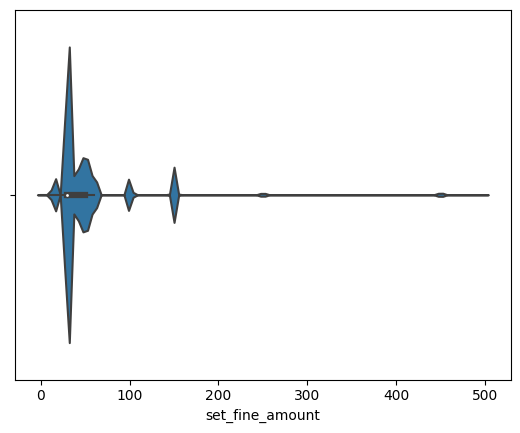

In [88]:
# violin plot to check distribution and outliers of  fine amount column

'''We can see that most of the fine amounts range between 20-50. Some fine amounts at $100 and some at $150. 
Very few amount ranges above 200.'''


sns.violinplot(x=df_parking_tickets["set_fine_amount"])

<AxesSubplot: xlabel='set_fine_amount'>

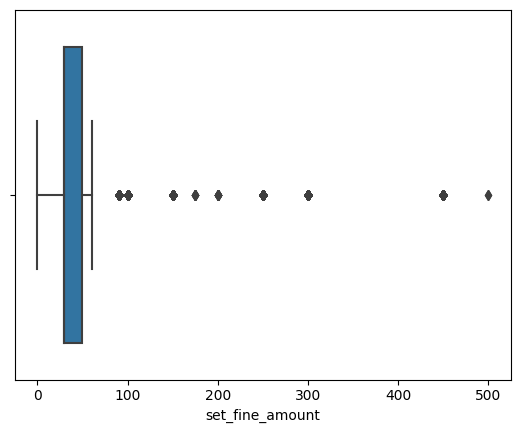

In [89]:
# box plot to understand median, 25 percentile, 75 percentile and outliers in the fine amount data
''' $30 is the median value of fine amount column. The plot shows data as outliers if the fine amount is 100 or above 100. '''
sns.boxplot(x=df_parking_tickets["set_fine_amount"])

In [90]:
# only two instances with fine $500.
df_parking_tickets[df_parking_tickets["set_fine_amount"]==500]

tag_number_masked  date_of_infraction  infraction_code  \
8795173          ***63751            20190329            437.0   
9050080          ***49129            20190216            437.0   

               infraction_description  set_fine_amount  time_of_infraction  \
8795173  PARK PRIVATE VEHICLE ON SITE              500              1858.0   
9050080  PARK PRIVATE VEHICLE ON SITE              500              1821.0   

        location1               location2 province  
8795173        AT          800 BOROUGH DR       ON  
9050080        AT  95 THORNCLIFFE PARK DR       MI

In [92]:
''' checking date column for anomalies. 

There are 41 data points which shows time above 23:59 which is not real.'''

len(df_parking_tickets[df_parking_tickets["time_of_infraction"]>2359])

41

In [93]:
'''
Dropping data with unreal time stamps. 
Checking data sanity after dropping unreal time stamps.'''
df_parking_tickets = df_parking_tickets.drop(df_parking_tickets[df_parking_tickets["time_of_infraction"]>2359].index)
len(df_parking_tickets[df_parking_tickets["time_of_infraction"]>2359])

0

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/148736936.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<AxesSubplot: xlabel='infraction_code', ylabel='Density'>

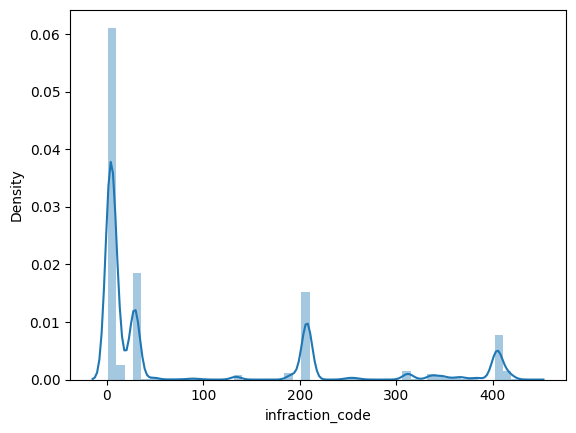

In [95]:
# plotting infraction code histogram to check data distribution

sns.distplot(df_parking_tickets["infraction_code"])

- from the above histogram, it is obvious that infraction codes between 0-20, 30-50, 200-220 and 400-420 have the more frequency. These parking ticket infractions have more probability to happen.

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/3152826384.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<AxesSubplot: xlabel='time_of_infraction', ylabel='Density'>

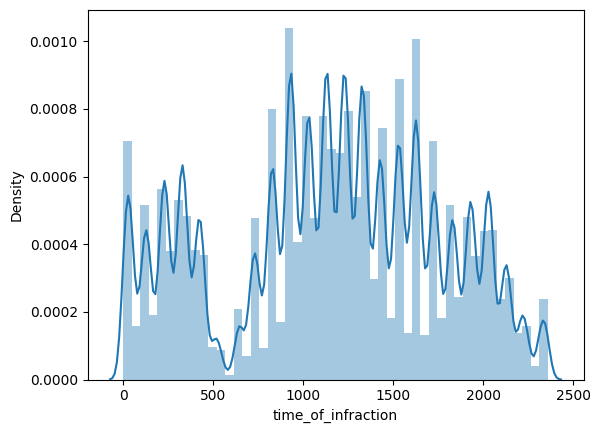

In [96]:
# plotting the infraction time histogram
sns.distplot(df_parking_tickets["time_of_infraction"])

- There are least infractions between 5 am and 6 am. More parking infractions are observed 9 am to 3 pm. 

<AxesSubplot: xlabel='time_of_infraction'>

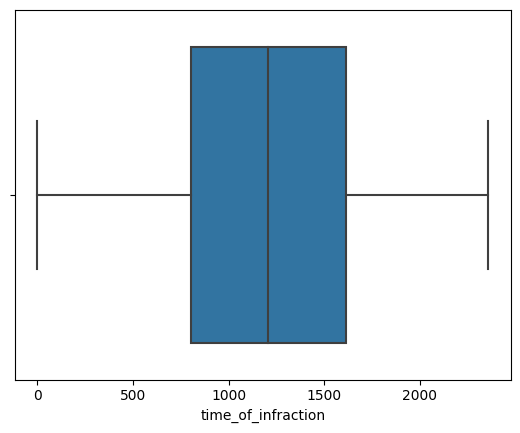

In [97]:
# boxplot for time of infraction
sns.boxplot(x=df_parking_tickets["time_of_infraction"])

# TOP 20 PARKING INFRACTION:

In [153]:
# Counting Infraction descriptions
df_parking_tickets['infraction_description'].value_counts()

PARK ON PRIVATE PROPERTY          1924475
PARK-SIGNED HWY-PROHIBIT DY/TM    1657465
PARK PROHIBITED TIME NO PERMIT    1413706
PARK MACHINE-REQD FEE NOT PAID    1117044
STOP-SIGNED HWY-PROHIBIT TM/DY     494655
                                   ...   
PARK NOT WITHIN PERMITTED TIME          1
STOP-WITHIN SCHOOL BUS LOAD ZN          1
PARK VEH.-PROHIBITED AREA SNOW          1
STOP/STAND/PARK NOT DESIG AREA          1
STAND HANDICAP LOADING ZONE             1
Name: infraction_description, Length: 277, dtype: int64

In [154]:
''' There are different infraction description for each code. This might be due to inputing incorrect information. 
From the below examples, we can see that there are very few variants in description and 
we can safely choose the reason with the highest counts as other variants of the description have the same context as the first one.
So I decided to calculate top 20 infraction based on the infraction code rather than couting with infraction description.'''

df_parking_tickets[df_parking_tickets['infraction_code']==3]['infraction_description'].value_counts()

PARK ON PRIVATE PROPERTY          1924475
PARK PRIVATE PROP NO CONSENT           43
PARK ON PRIV PROP NO CONSENT           36
PARK VEH PRIVATE PRO NO CONSEN          4
PARK ON PRIV PROP WITHOUT CONS          2
PARK - LONGER THAN 3 HOURS              1
Name: infraction_description, dtype: int64

In [155]:
df_parking_tickets[df_parking_tickets['infraction_code']==5]['infraction_description'].value_counts()

PARK-SIGNED HWY-PROHIBIT DY/TM    1657462
PARK-HWY DRNG PROH TIMES/DAYS          40
PARK HWY AT PROHIB TIME/DAY            27
PARK-HWY PROHIB TIMES/DAYS             18
PARK HWY PROHIBITED TIMES/DAYS         12
PARK HWY PRO TIMES/DAYS                 5
PARK SIGNED HWY PRO TIMES/DAYS          1
Name: infraction_description, dtype: int64

In [156]:
df_parking_tickets[df_parking_tickets['infraction_code']==29]['infraction_description'].value_counts()

PARK PROHIBITED TIME NO PERMIT    1413706
Park Prohibited Area No Permit          2
PARK-SIGNED HWY-PROHIBIT DY/TM          1
PARK VEH ON ST WITHOUT PERMIT           1
PARK/STAND/STOP NO PERMIT               1
Name: infraction_description, dtype: int64

In [157]:
# Counting top 20 infraction codes

top_infraction_code = pd.DataFrame(df_parking_tickets['infraction_code'].value_counts()).sort_values(by='infraction_code', ascending=False)
top_infraction_code.reset_index(inplace=True) # reset index
top_infraction_code.columns = ['infraction_code', 'infraction_count'] # rename columns
top_20_infraction_code = top_infraction_code.iloc[:20] # slicing data for only top 20 infraction
top_20_infraction_code

infraction_code  infraction_count
0               3.0           1924561
1               5.0           1657565
2              29.0           1413711
3             207.0           1117044
4               2.0            564639
5               9.0            494694
6             406.0            363182
7               8.0            346066
8             403.0            302116
9               6.0            278806
10            210.0            213396
11             15.0            141925
12             28.0            126249
13            312.0            109748
14            192.0            103007
15              4.0             90471
16            415.0             83468
17             30.0             68413
18            347.0             64705
19            134.0             62839

In [158]:
# Finding Infraction reasons and most common location for top 20 infraction types and 

location = [] # empty list to append locations
infraction_reason = [] # empty list to append infraction reason

# finding most common location for each of the infraction types by using highest frequency of the location
for code in top_20_infraction_code['infraction_code'].values:
    loc = df_parking_tickets[df_parking_tickets['infraction_code']==code]['location2'].value_counts().index[0]
    location.append(loc)
    
# finding infraction descriptions for each infraction code
for code in top_20_infraction_code['infraction_code'].values:
    des = df_parking_tickets[df_parking_tickets['infraction_code']==code]['infraction_description'].value_counts().index[0]
    infraction_reason.append(des)

top_20_infraction_code['location'] = location # assigning a location column

top_20_infraction_code['infraction_description'] = infraction_reason # assigning infraction description column

top_20_infraction_code # final result with top 20 infraction types and their most common locations

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/1911397317.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/1911397317.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



infraction_code  infraction_count                  location  \
0               3.0           1924561          2075 BAYVIEW AVE   
1               5.0           1657565              20 EDWARD ST   
2              29.0           1413711           100 MAITLAND ST   
3             207.0           1117044       15 MARINE PARADE DR   
4               2.0            564639      151 VILLAGE GREEN SQ   
5               9.0            494694           42 CHARLES ST E   
6             406.0            363182       15 MARINE PARADE DR   
7               8.0            346066       19 GRAND TRUNK CRES   
8             403.0            302116             33 COLLEGE ST   
9               6.0            278806              2 SUSSEX AVE   
10            210.0            213396       15 MARINE PARADE DR   
11             15.0            141925           99 ATLANTIC AVE   
12             28.0            126249  100 HARRISON GARDEN BLVD   
13            312.0            109748            1155 KING ST W   
14            192.0            103007            720 QUEEN ST W   
15              4.0             90471             18 HENDON AVE   
16            415.0             83468             24 BELLAIR ST   
17             30.0             68413          185 FREDERICK ST   
18            347.0             64705         1090 DON MILLS RD   
19            134.0             62839             60 BLOOR ST W   

            infraction_description  
0         PARK ON PRIVATE PROPERTY  
1   PARK-SIGNED HWY-PROHIBIT DY/TM  
2   PARK PROHIBITED TIME NO PERMIT  
3   PARK MACHINE-REQD FEE NOT PAID  
4       PARK - LONGER THAN 3 HOURS  
5   STOP-SIGNED HWY-PROHIBIT TM/DY  
6    PARK-VEH. W/O VALID ONT PLATE  
7     STAND VEH.-PROHIBIT TIME/DAY  
8    STOP-SIGNED HIGHWAY-RUSH HOUR  
9   PARK-SIGNED HWY-EXC PERMT TIME  
10    PARK FAIL TO DISPLAY RECEIPT  
11  PARK-WITHIN 3M OF FIRE HYDRANT  
12  PARK-N.YORK 2AM-6AM DEC1-MAR31  
13    PARKING MACH-NOT USED/NO FEE  
14       STAND SIGNED TRANSIT STOP  
15      PARK ON MUNICIPAL PROPERTY  
16  PARK COMMERC LOAD ZONE NOT LDG  
17  STOP-(ON/OVER) (SIDEWK/FTPATH)  
18            PARK IN A FIRE ROUTE  
19     PARK-SIGNED HWY-PUBLIC LANE

# GREEN P PARKING DATA:

In [35]:
# Using get_url function to get urls to fetch data
green_parking_urls = get_url("green-p-parking")
green_parking_urls

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/b66466c3-69c8-4825-9c8b-04b270069193/resource/8549d588-30b0-482e-b872-b21beefdda22/download/green-p-parking-2019.json',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/b66466c3-69c8-4825-9c8b-04b270069193/resource/31abc7f3-0796-42d9-9ed2-22d216ae338b/download/green-p-parking-2015.json',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/b66466c3-69c8-4825-9c8b-04b270069193/resource/dba88efd-f692-4ce2-ae77-d0ec3f08bd21/download/green-p-parking-readme.xls']

In [36]:
''' 
We have to combine 2019 and 2015 json files by accessing the urls.
For that we need to slice the green_parking_urls list and use only json file urls.
'''

dfs = []
for url in range(len(green_parking_urls)-1):

    resp = requests.get(green_parking_urls[url])  # requesting url
    txt = resp.json() # reading json file
    df = pd.DataFrame(txt['carparks'])  # accessing text with carpark key in the json files
    dfs.append(df) # appending dataframes 
    
green_parking_df = pd.concat(dfs, axis=0) # concating data for 2019 and 2015 dataframes
green_parking_df = green_parking_df.reset_index(drop= True) # reset index
green_parking_df # final green p parking dataframe

/Users/harshpanchal/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.

/Users/harshpanchal/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/core/formatters.py:342: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



id                                               slug  \
0      1  https://parking.greenp.com/carpark/1_20-charle...   
1      3  https://parking.greenp.com/carpark/3_13-isabel...   
2      5  https://parking.greenp.com/carpark/5_15-welles...   
3     11  https://parking.greenp.com/carpark/11_21-pleas...   
4     12  https://parking.greenp.com/carpark/12_30-alvin...   
..   ...                                                ...   
486  269                                                NaN   
487  272                                                NaN   
488  534                                                NaN   
489  273                                                NaN   
490  711                                                NaN   

                      address                 lat                 lng  \
0      20 Charles Street East  43.669282202140174   -79.3852894625656   
1          13 Isabella Street           43.667577          -79.384707   
2    15 Wellesley Street East           43.664837          -79.383591   
3           21 Pleasant Blvd.           43.687092          -79.392850   
4             30 Alvin Avenue   43.68919056469554  -79.39269983525526   
..                        ...                 ...                 ...   
486            1010 Yonge St.           43.675942          -79.389439   
487      775 King Street West           43.642808          -79.405092   
488    15 Marine Parade Drive           43.628862          -79.475564   
489         20 Erskine Avenue           43.711355          -79.398550   
490         158 Borough Drive           43.772181          -79.256377   

                  rate carpark_type carpark_type_str  is_ttc  \
0    $2.50 / Half Hour       garage           Garage   False   
1    $3.00 / Half Hour      surface          Surface   False   
2    $3.00 / Half Hour      surface          Surface   False   
3    $3.00 / Half Hour       garage           Garage   False   
4    $3.50 / Half Hour      surface          Surface   False   
..                 ...          ...              ...     ...   
486  $1.25 / Half Hour      surface          Surface   False   
487  $1.50 / Half Hour       garage           Garage   False   
488  $1.00 / Half Hour      surface          Surface   False   
489  $1.50 / Half Hour      surface          Surface   False   
490  $1.00 / Half Hour      surface          Surface   False   

    is_under_construction  ... monthly_permit_quantity monthly_permit_price  \
0                   False  ...                                                
1                   False  ...                                                
2                   False  ...                                                
3                   False  ...                                       180.00   
4                   False  ...                                                
..                    ...  ...                     ...                  ...   
486                   NaN  ...                     NaN                  NaN   
487                   NaN  ...                     NaN                  NaN   
488                   NaN  ...                     NaN                  NaN   
489                   NaN  ...                     NaN                  NaN   
490                   NaN  ...                     NaN                  NaN   

      map_marker_logo                                          alert_box  \
0         greenp_only  Monthly Permits are no longer available at thi...   
1         greenp_only                                                      
2    greenp_bikeshare                                                      
3         greenp_only                                                      
4         greenp_only                                                      
..                ...                                                ...   
486               NaN                                                NaN   
487               NaN                         

In [37]:
green_parking_df.columns

Index(['id', 'slug', 'address', 'lat', 'lng', 'rate', 'carpark_type',
       'carpark_type_str', 'is_ttc', 'is_under_construction', 'changing_rates',
       'rate_half_hour', 'capacity', 'max_height', 'bike_racks',
       'payment_methods', 'payment_options', 'rate_details',
       'monthly_permit_status', 'monthly_permit_quantity',
       'monthly_permit_price', 'map_marker_logo', 'alert_box',
       'enable_streetview', 'streetview_lat', 'streetview_long',
       'streetview_yaw', 'streetview_pitch', 'streetview_zoom'],
      dtype='object')

## LOCATIONS OF ALL GREEN P PARKING SPOTS:

In [42]:
# Green p Parking location spots using plotly library

green_map = px.scatter_mapbox(green_parking_df, lat = "lat", lon = "lng", zoom=9, center = {'lat':center_lat, 'lon':center_lon},
                  hover_data = {"address": True, "carpark_type": True, "is_ttc": True, "capacity": True},
                  title= "Green P Parking Location", mapbox_style="carto-positron", height = 800, size_max=30)

green_map.update_traces(marker = go.scattermapbox.Marker(size=10, color = "green"))

green_map.show()

In [203]:
# checking null values in each column for green p parking dataset

''' There are several columns with almost 49%  null values. 
This is due to 2019 dataset has some additional columns that 2015 does not.
This caused this high number of null values in the dataset. 
'''
green_parking_df.isnull().sum()/len(green_parking_df)*100

id                          0.000000
slug                       48.676171
address                     0.000000
lat                         0.000000
lng                         0.000000
rate                        0.000000
carpark_type                0.000000
carpark_type_str            0.000000
is_ttc                      0.000000
is_under_construction      48.676171
changing_rates             48.676171
rate_half_hour              0.000000
capacity                    0.000000
max_height                  9.775967
bike_racks                 48.676171
payment_methods             0.000000
payment_options             0.000000
rate_details                0.000000
monthly_permit_status      48.676171
monthly_permit_quantity    48.676171
monthly_permit_price       48.676171
map_marker_logo            48.676171
alert_box                  48.676171
enable_streetview           6.517312
streetview_lat              6.517312
streetview_long             6.517312
streetview_yaw              6.517312
s

# ONE ADDRESS REPOSITORY/ MUNICIPAL ADDRESSES:

In [211]:
# Get urls for municipal addresses 
municipal_add_urls = get_url("address-points-municipal-toronto-one-address-repository")
municipal_add_urls

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/abedd8bc-e3dd-4d45-8e69-79165a76e4fa/resource/921563fc-aeab-4e1f-82bd-c7bdae6dc26a/download/readme-address-feature-codes.txt',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/abedd8bc-e3dd-4d45-8e69-79165a76e4fa/resource/bdb0a332-aa84-42de-ac49-214cc68bb5ee/download/address_point_wgs84_geojson.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/abedd8bc-e3dd-4d45-8e69-79165a76e4fa/resource/eba07dba-8645-45f8-950c-0381a0dcaa1b/download/municipal-address-points-wgs84-latitude-longitude.zip']

In [213]:
# downloading geojson and shape files from zip folder using urls and unzip it in the provided path

for i in range(len(municipal_add_urls)-1):
    getfolder = requests.get(municipal_add_urls[1:][i])
    unzipfolder = zipfile.ZipFile(BytesIO(getfolder.content))
    unzipfolder.extractall("/Users/harshpanchal/Desktop/City of Toronto/municipal_address/") # the code will dump all the files from the url in the given folder

In [47]:
''' accessing shape file using geopandas library. 
We are converting it into data frame and then will access it to plot the map'''


muni_add_shape = "/Users/harshpanchal/Desktop/City of Toronto/municipal_address/ADDRESS_POINT_WGS84.shp"
muni_add_df = gpd.read_file(muni_add_shape)
muni_add_df.to_crs(CRS.from_epsg(4326), inplace = True)
muni_add_df = muni_add_df.reset_index(drop=True)
muni_add_df

GEO_ID      LINK MAINT_STAG ADDRESS              LFNAME  LO_NUM  \
0        5729529   5729516    REGULAR     399      Lake Promenade     399   
1        9950585   9950578    REGULAR       7             Hilo Rd       7   
2        5729496   5729468    REGULAR     387      Lake Promenade     387   
3        5729341   5729332    REGULAR     321      Lake Promenade     321   
4        7304577   7304570    REGULAR      22     Thirty Sixth St      22   
...          ...       ...        ...     ...                 ...     ...   
525363  30124115  30123659   RESERVED     125  Green Gardens Blvd     125   
525364  30124106  30123659   RESERVED     107  Green Gardens Blvd     107   
525365  30124109  30123659   RESERVED     113  Green Gardens Blvd     113   
525366  30124107  30123659   RESERVED     109  Green Gardens Blvd     109   
525367  30124114  30123659   RESERVED     123  Green Gardens Blvd     123   

       LONUMSUF  HINUM HINUMSUF ARC_SIDE  ...  CLASS  NAME           X  \
0          None    NaN     None        L  ...   Land  None  301607.151   
1          None    NaN     None        L  ...   Land  None  301540.011   
2          None    NaN     None        L  ...   Land  None  301648.488   
3          None    NaN     None        L  ...   Land  None  301926.249   
4          None    NaN     None        L  ...   Land  None  301937.384   
...         ...    ...      ...      ...  ...    ...   ...         ...   
525363     None    NaN     None        L  ...   Land  None  309281.807   
525364     None    NaN     None        L  ...   Land  None  309323.224   
525365     None    NaN     None        L  ...   Land  None  309310.661   
525366     None    NaN     None        L  ...   Land  None  309319.918   
525367     None    NaN     None        L  ...   Land  None  309288.892   

                  Y  LONGITUDE   LATITUDE   OBJECTID    MUN_NAME  \
0       4827443.931 -79.539542  43.586930  1491585.0   Etobicoke   
1       4827592.989 -79.540374  43.588272  1491586.0   Etobicoke   
2       4827472.065 -79.539030  43.587184  1491591.0   Etobicoke   
3       4827620.088 -79.535591  43.588517  1491594.0   Etobicoke   
4       4827737.920 -79.535454  43.589578  1491597.0   Etobicoke   
...             ...        ...        ...        ...         ...   
525363  4842574.419 -79.444374  43.723110  4619397.0  North York   
525364  4842588.562 -79.443860  43.723237  4619414.0  North York   
525365  4842585.257 -79.444016  43.723207  4619417.0  North York   
525366  4842587.596 -79.443901  43.723228  4619423.0  North York   
525367  4842576.559 -79.444286  43.723129  4619426.0  North York   

                  WARD_NAME                    geometry  
0       Etobicoke-Lakeshore  POINT (-79.53954 43.58692)  
1       Etobicoke-Lakeshore  POINT (-79.54037 43.58826)  
2       Etobicoke-Lakeshore  POINT (-79.53903 43.58717)  
3       Etobicoke-Lakeshore  POINT (-79.53559 43.58851)  
4       Etobicoke-Lakeshore  POINT (-79.53545 43.58957)  
...                     ...                         ...  
525363    Eglinton-Lawrence  POINT (-79.44437 43.72311)  
525364    Eglinton-Lawrence  POINT (-79.44386 43.72324)  
525365    Eglinton-Lawrence  POINT (-79.44402 43.72321)  
525366    Eglinton-Lawrence  POINT (-79.44390 43.72323)  
525367    Eglinton-Lawrence  POINT (-79.44429 43.72313)  

[525368 rows x 23 columns]

In [48]:
muni_add_df.columns # all columns

Index(['GEO_ID', 'LINK', 'MAINT_STAG', 'ADDRESS', 'LFNAME', 'LO_NUM',
       'LONUMSUF', 'HINUM', 'HINUMSUF', 'ARC_SIDE', 'DISTANCE', 'FCODE',
       'FCODE_DES', 'CLASS', 'NAME', 'X', 'Y', 'LONGITUDE', 'LATITUDE',
       'OBJECTID', 'MUN_NAME', 'WARD_NAME', 'geometry'],
      dtype='object')

- We need to find the coordinates of top 20 infractions' location. For that we need to modify the location column from the top_20_infraction_code dataframe.
- Once we modify it (splitting location column into streetno. and streetname), we fetch data from municipal address dataframe to get latitude and longitude of the top 20 infraction sites. 

In [159]:
# splitting location column into street no and street name columns in the top 20 infraction dataframe
top_20_infraction_code[['StreetNo','StreetName']] = top_20_infraction_code['location'].str.split(" ", n=1, expand=True)


/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/1512408584.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/1512408584.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
''' Matching street number and street name from the top_20_infraction_Code dataframe to muni_add_df. 
After matching these locations we get final latitude and longitude for top 20 infraction sites.
'''


infract_geo_loc = pd.DataFrame()
for i in range(len(top_20_infraction_code)):
    temp_df = muni_add_df[(muni_add_df['LFNAME'].str.lower()==top_20_infraction_code['StreetName'][i].lower()) 
                          & (muni_add_df['ADDRESS']==top_20_infraction_code['StreetNo'][i])]
    # infract_geo_loc = pd.append(muni_add_df[(muni_add_df['LFNAME'].str.lower()==top_20_infraction_code['StreetName'][i].lower()) 
    #                       & (muni_add_df['ADDRESS']==top_20_infraction_code['StreetNo'][i])])
    
    infract_geo_loc = infract_geo_loc.append(temp_df, ignore_index=True)
    
infract_geo_loc

/var/folders/3c/glrbsvd11fvd6l99vhb0q_y40000gn/T/ipykernel_51530/530118759.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



GEO_ID      LINK MAINT_STAG ADDRESS                LFNAME  LO_NUM  \
0    7754918  30092435    REGULAR    2075           Bayview Ave    2075   
1    7762734   7762735    REGULAR      20             Edward St      20   
2   30113626   7762735   RESERVED      20             Edward St      20   
3     836565   1143002    REGULAR     100           Maitland St     100   
4   20103199  30042683    REGULAR      15      Marine Parade Dr      15   
5   30030137  30030132    REGULAR     151      Village Green Sq     151   
6   30067780  14023731    REGULAR      42          Charles St E      42   
7   20103199  30042683    REGULAR      15      Marine Parade Dr      15   
8   30041064  14621076    REGULAR      19      Grand Trunk Cres      19   
9   30139724  14020372    REGULAR      33            College St      33   
10   9941738   9941737    REGULAR       2            Sussex Ave       2   
11  20103199  30042683    REGULAR      15      Marine Parade Dr      15   
12   6023104  14673880    REGULAR      99          Atlantic Ave      99   
13  30016610  30076031    REGULAR     100  Harrison Garden Blvd     100   
14  14121184  30100483    REGULAR    1155             King St W    1155   
15   7570387   7570350    REGULAR     720            Queen St W     720   
16  30032014  30126899    REGULAR      18            Hendon Ave      18   
17   7974969   7974927    REGULAR      24            Bellair St      24   
18    806436   1145215    REGULAR     185          Frederick St     185   
19  30010067  30018925   RESERVED    1090          Don Mills Rd    1090   
20    508018  30018925    REGULAR    1090          Don Mills Rd    1090   
21   8408500   8408494    REGULAR      60            Bloor St W      60   

   LONUMSUF  HINUM HINUMSUF ARC_SIDE  ...               CLASS  \
0      None    NaN     None        R  ...                Land   
1      None    NaN     None        R  ...                Land   
2      None    NaN     None        R  ...                Land   
3      None    NaN     None        L  ...                Land   
4      None    NaN     None        L  ...                Land   
5      None    NaN     None        R  ...                Land   
6      None    NaN     None        L  ...                Land   
7      None    NaN     None        L  ...                Land   
8      None    NaN     None        R  ...                Land   
9      None    NaN     None        L  ...  Structure Entrance   
10     None    NaN     None        R  ...                Land   
11     None    NaN     None        L  ...                Land   
12     None    NaN     None        R  ...  Structure Entrance   
13     None    NaN     None        R  ...                Land   
14     None    NaN     None        L  ...                Land   
15     None    NaN     None        R  ...                Land   
16     None    NaN     None        R  ...                Land   
17     None    NaN     None        L  ...                Land   
18     None    NaN     None        R  ...  Structure Entrance   
19     None    NaN     None        L  ...                Land   
20     None    NaN     None        L  ...                Land   
21     None    NaN     None        R  ...                Land   

                              NAME           X            Y  LONGITUDE  \
0   Sunnybrook Hosp, Ambulance  57  314639.798  4842449.949 -79.377875   
1                             None  314278.549  4835246.806 -79.382486   
2                             None  314302.635  4835241.780 -79.382187   
3                             None  314503.678  4836132.177 -79.379682   
4           Humber Bay Shores Park  306777.353  4832116.565 -79.475496   
5                             None  322414.761  4848758.795 -79.281172   
6                             None  314139.783  4836607.484 -79.384182   
7           Humber Bay Shores Park  306777.353  4832116.565 -79.475496   
8                             None  314267.661  4833530.719 -79.382651   
9                             None  314062.1

In [124]:
infract_geo_loc = infract_geo_loc[infract_geo_loc['MAINT_STAG'] !='RESERVED'] # removing reserved locations
infract_geo_loc =infract_geo_loc.reset_index(drop=True)
infract_geo_loc['Infraction Type'] = top_20_infraction_code['infraction_description'] #adding infraction description
infract_geo_loc['Infraction Code'] = top_20_infraction_code['infraction_code'] # adding infraction code
infract_geo_loc

GEO_ID      LINK MAINT_STAG ADDRESS                LFNAME  LO_NUM  \
0    7754918  30092435    REGULAR    2075           Bayview Ave    2075   
1    7762734   7762735    REGULAR      20             Edward St      20   
2     836565   1143002    REGULAR     100           Maitland St     100   
3   20103199  30042683    REGULAR      15      Marine Parade Dr      15   
4   30030137  30030132    REGULAR     151      Village Green Sq     151   
5   30067780  14023731    REGULAR      42          Charles St E      42   
6   20103199  30042683    REGULAR      15      Marine Parade Dr      15   
7   30041064  14621076    REGULAR      19      Grand Trunk Cres      19   
8   30139724  14020372    REGULAR      33            College St      33   
9    9941738   9941737    REGULAR       2            Sussex Ave       2   
10  20103199  30042683    REGULAR      15      Marine Parade Dr      15   
11   6023104  14673880    REGULAR      99          Atlantic Ave      99   
12  30016610  30076031    REGULAR     100  Harrison Garden Blvd     100   
13  14121184  30100483    REGULAR    1155             King St W    1155   
14   7570387   7570350    REGULAR     720            Queen St W     720   
15  30032014  30126899    REGULAR      18            Hendon Ave      18   
16   7974969   7974927    REGULAR      24            Bellair St      24   
17    806436   1145215    REGULAR     185          Frederick St     185   
18    508018  30018925    REGULAR    1090          Don Mills Rd    1090   
19   8408500   8408494    REGULAR      60            Bloor St W      60   

   LONUMSUF  HINUM HINUMSUF ARC_SIDE  ...           X            Y  LONGITUDE  \
0      None    NaN     None        R  ...  314639.798  4842449.949 -79.377875   
1      None    NaN     None        R  ...  314278.549  4835246.806 -79.382486   
2      None    NaN     None        L  ...  314503.678  4836132.177 -79.379682   
3      None    NaN     None        L  ...  306777.353  4832116.565 -79.475496   
4      None    NaN     None        R  ...  322414.761  4848758.795 -79.281172   
5      None    NaN     None        L  ...  314139.783  4836607.484 -79.384182   
6      None    NaN     None        L  ...  306777.353  4832116.565 -79.475496   
7      None    NaN     None        R  ...  314267.661  4833530.719 -79.382651   
8      None    NaN     None        L  ...  314062.103  4835648.030 -79.385162   
9      None    NaN     None        R  ...  312896.833  4836184.465 -79.399605   
10     None    NaN     None        L  ...  306777.353  4832116.565 -79.475496   
11     None    NaN     None        R  ...  311214.810  4833215.889 -79.420497   
12     None    NaN     None        R  ...  312498.163  4846340.380 -79.404400   
13     None    NaN     None        L  ...  310993.755  4833233.421 -79.423233   
14     None    NaN     None        R  ...  312124.348  4834055.136 -79.409213   
15     None    NaN     None        R  ...  311460.319  4849067.831 -79.417255   
16     None    NaN     None        L  ...  313565.361  4836749.226 -79.391306   
17     None    NaN     None        R  ...  315338.040  4834613.783 -79.369366   
18     None    NaN     None        L  ...  317347.866  4844065.171 -79.344230   
19     None    NaN     None        R  ...  313747.208  4836683.735 -79.389053   

     LATITUDE   OBJECTID        MUN_NAME              WARD_NAME  \
0   43.721938  4198065.0      North York        Don Valley West   
1   43.657105  4526353.0  former Toronto    University-Rosedale   
2   43.665080  2448098.0  former Toronto         Toronto Centre   
3   43.628986  3836388.0       Etobicoke    Etobicoke-Lakeshore   
4   43.778581  4461799.0     Scarborough  Scarborough-Agincourt   
5   43.669355  4592243.0  former Toronto    University-Rosedale   
6   43.628986  3836388.0       Etobicoke    Etobicoke-Lakeshore   
7   43.641658  4575970.0  former Toronto      Spadina-Fort York   
8   43.660719  4609553.0  former Toronto    University-Rosedale   
9   43.665570  2986735.0  former Toronto    University-Ros

# NEIGHBOURHOOD PROFILE:

In [127]:
# Get neighbourhood prfile data from urls
neighbor_prof_url = get_url("neighbourhood-profiles")
neighbor_prof_url

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/f07fe8f0-fa24-4d68-8cb4-326e280b0b05/download/neighbourhood-profiles-2016-140-model.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/46bec89b-90bc-4545-b5d9-4e1eb7337d87/download/neighbourhood-profiles-2016-140-model.xml',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/fe8f49c5-b629-49b9-9453-7f41f0f3fdea/download/neighbourhood-profiles-2016-140-model.json',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/9d2474eb-46ed-4970-9a38-b635703ed5c6/download/neighbourhood-profiles-2011-140-model.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/8b4813a5-d4d7-4f34-8614-dfc07c46949b/download/neighbourhood-profiles-2011-140-model.xml',
 'https://ckan0.cf.opendata.i

In [128]:
# I want to deal with only csv files so extracting urls with csv file format
neighbor_prof_url_csvs = []
for i in neighbor_prof_url:
    if ".csv" in i:
        neighbor_prof_url_csvs.append(i)
        
neighbor_prof_url_csvs
        

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/f07fe8f0-fa24-4d68-8cb4-326e280b0b05/download/neighbourhood-profiles-2016-140-model.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/9d2474eb-46ed-4970-9a38-b635703ed5c6/download/neighbourhood-profiles-2011-140-model.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/dece8848-9529-4c36-8344-2d47fa152e79/download/neighbourhood-profiles-2006-140-model.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/6e19a90f-971c-46b3-852c-0c48c436d1fc/resource/3e7072b4-76f4-4ac6-92d4-0e58b1560986/download/neighbourhood-profiles-2001-140-model.csv']

In [144]:
# merging csv data files into single dataframe
neighbor_prof_df = pd.concat(pd.read_csv(i) for i in neighbor_prof_url_csvs)
neighbor_prof_df = neighbor_prof_df.reset_index(drop= True)
neighbor_prof_df

_id                   Category  \
0       1  Neighbourhood Information   
1       2  Neighbourhood Information   
2       3                 Population   
3       4                 Population   
4       5                 Population   
...   ...                        ...   
6136  762                   Mobility   
6137  763                   Mobility   
6138  764                   Mobility   
6139  765                   Mobility   
6140  766                   Mobility   

                                                 Topic  \
0                            Neighbourhood Information   
1                            Neighbourhood Information   
2                             Population and dwellings   
3                             Population and dwellings   
4                             Population and dwellings   
...                                                ...   
6136  Mobility status - Place of residence 5 years ago   
6137  Mobility status - Place of residence 5 years ago   
6138  Mobility status - Place of residence 5 years ago   
6139  Mobility status - Place of residence 5 years ago   
6140  Mobility status - Place of residence 5 years ago   

                         Data Source               Characteristic  \
0                    City of Toronto         Neighbourhood Number   
1                    City of Toronto         TSNS2020 Designation   
2     Census Profile 98-316-X2016001             Population, 2016   
3     Census Profile 98-316-X2016001             Population, 2011   
4     Census Profile 98-316-X2016001  Population Change 2011-2016   
...                              ...                          ...   
6136                             NaN                          NaN   
6137                             NaN                          NaN   
6138                             NaN                          NaN   
6139                             NaN                          NaN   
6140                             NaN                          NaN   

     City of Toronto Agincourt North Agincourt South-Malvern West  \
0                NaN             129                          128   
1                NaN  No Designation               No Designation   
2          2,731,571          29,113                       23,757   
3          2,615,060          30,279                       21,988   
4              4.50%          -3.90%                        8.00%   
...              ...             ...                          ...   
6136        417505.0          4475.0                       3260.0   
6137        163035.0          1000.0                        860.0   
6138        114510.0           785.0                        600.0   
6139         48525.0           215.0                        255.0   
6140        254470.0          3470.0                       2405.0   

           Alderwood           Annex Banbury-Don Mills  Bathurst Manor  \
0                 20              95                42              34   
1     No Designation  No Designation    No Designation  No Designation   
2             12,054          30,526            27,695          15,873   
3             11,904          29,177            26,918          15,434   
4              1.30%           4.60%             2.90%           2.80%   
...              ...             ...               ...             ...   
6136          1080.0          6515.0            3425.0          2000.0   
6137           695.0          4105.0            1315.0           835.0   
6138           575.0          2545.0            1010.0           660.0   
6139           115.0          1570.0             305.0           175.0   
6140           385.0          2390.0            2110.0          1170.0   

     Bay Street Corridor Bayview Village Bayview Woods-Steeles  \
0                     76              52                    49   
1         No Designation  No Designation        No Designation   
2                 25,797          21,396                13,154   
3                

In [187]:
neighbor_prof_df[["Category","Topic","Characteristic",'Annex','Bay Street Corridor','Church-Yonge Corridor',
                  'Mimico (includes Humber Bay Shores)', 'Moss Park', 'Niagara', 'Waterfront Communities-The Island'
                  ,'Attribute']]

Category  \
0     Neighbourhood Information   
1     Neighbourhood Information   
2                    Population   
3                    Population   
4                    Population   
...                         ...   
6136                   Mobility   
6137                   Mobility   
6138                   Mobility   
6139                   Mobility   
6140                   Mobility   

                                                 Topic  \
0                            Neighbourhood Information   
1                            Neighbourhood Information   
2                             Population and dwellings   
3                             Population and dwellings   
4                             Population and dwellings   
...                                                ...   
6136  Mobility status - Place of residence 5 years ago   
6137  Mobility status - Place of residence 5 years ago   
6138  Mobility status - Place of residence 5 years ago   
6139  Mobility status - Place of residence 5 years ago   
6140  Mobility status - Place of residence 5 years ago   

                   Characteristic           Annex Bay Street Corridor  \
0            Neighbourhood Number              95                  76   
1            TSNS2020 Designation  No Designation      No Designation   
2                Population, 2016          30,526              25,797   
3                Population, 2011          29,177              19,348   
4     Population Change 2011-2016           4.60%              33.30%   
...                           ...             ...                 ...   
6136                          NaN          6515.0              5355.0   
6137                          NaN          4105.0              2990.0   
6138                          NaN          2545.0              1995.0   
6139                          NaN          1570.0              1000.0   
6140                          NaN          2390.0              2360.0   

     Church-Yonge Corridor Mimico (includes Humber Bay Shores)  \
0                       75                                  17   
1           No Designation                      No Designation   
2                   31,340                              33,964   
3                   28,349                              26,541   
4                   10.60%                              28.00%   
...                    ...                                 ...   
6136                6895.0                              4780.0   
6137                4495.0                              2545.0   
6138                3045.0                              1920.0   
6139                1450.0                               610.0   
6140                2405.0                              2245.0   

           Moss Park         Niagara Waterfront Communities-The Island  \
0                 73              82                                77   
1     No Designation  No Designation                    No Designation   
2             20,506          31,180                            65,913   
3             16,306          21,274                            43,361   
4             25.80%          46.60%                            52.00%   
...              ...             ...                               ...   
6136          1375.0          2785.0                            4815.0   
6137           440.0          1675.0                            3160.0   
6138           335.0          1265.0                            2320.0   
6139           110.0           415.0                             845.0   
6140           930.0          1105.0                            1675.0   

                             Attribute  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  
...                                ...  
6136                          Migrants  
6137              

# NEIGHBOURHOOD BOUNDRIES:

In [3]:
# Get urls from neighbourghood boundries api
neighbor_map_url = get_url("neighbourhoods")
neighbor_map_url

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/2ab99ca3-287d-4974-8701-54a361dd9b20/download/neighbourhoods-historical-140-4326.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/ceab5f9a-9a16-4985-a9da-e4967895c129/download/neighbourhoods-historical-140-2952.csv',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/d4b0aa31-19a7-47ff-a828-6893e5c17eec/download/neighbourhoods-historical-140-4326.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/cf035a22-0a5c-4392-8342-dffbc394d66a/download/neighbourhoods-historical-140-2952.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/b36759ab-da2a-4dda-8946-f31975738a2c/download/neighbourhoods-historical-140-4326.gpkg',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/f139a2d3-132b-4bd6-85c8-ecff8976de19/download/neighbourhoods-historical-

In [4]:
# fetching data with zip file and with historical 140 
neighbor_map_url_csvs = []
for i in neighbor_map_url:
    if ".zip" in i and '-140' in i:
        neighbor_map_url_csvs.append(i)
        
neighbor_map_url_csvs

['https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/d4b0aa31-19a7-47ff-a828-6893e5c17eec/download/neighbourhoods-historical-140-4326.zip',
 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhoods/resource/cf035a22-0a5c-4392-8342-dffbc394d66a/download/neighbourhoods-historical-140-2952.zip']

In [5]:
# extrat data from the zip folder in url
getfolder = requests.get(neighbor_map_url_csvs[0])
unzipfolder = zipfile.ZipFile(BytesIO(getfolder.content))
unzipfolder.extractall("/Users/harshpanchal/Desktop/City of Toronto/neighbor_map/") # dump all data to the procided path

In [6]:
# access shape file to plot a map of a neighbour boundries
border_shape = "/Users/harshpanchal/Desktop/City of Toronto/neighbor_map/Neighbourhoods - historical 140.shp"
border_df = gpd.read_file(border_shape)
border_df.to_crs(CRS.from_epsg(4326), inplace = True)
border_df = border_df.reset_index(drop=True)
border_df

FIELD_1  FIELD_2   FIELD_3 FIELD_4  FIELD_5  FIELD_6  \
0          1  2501286  26022481    None       30       30   
1          2  2501285  26022480    None      106      106   
2          3  2501284  26022479    None       91       91   
3          4  2501283  26022478    None       48       48   
4          5  2501282  26022477    None      129      129   
..       ...      ...       ...     ...      ...      ...   
135      136  2501151  26022346    None       20       20   
136      137  2501150  26022345    None       21       21   
137      138  2501149  26022344    None      102      102   
138      139  2501148  26022343    None        8        8   
139      140  2501147  26022342    None      128      128   

                                FIELD_7                             FIELD_8  \
0              Brookhaven-Amesbury (30)            Brookhaven-Amesbury (30)   
1              Humewood-Cedarvale (106)            Humewood-Cedarvale (106)   
2               Weston-Pelham Park (91)             Weston-Pelham Park (91)   
3                Hillcrest Village (48)              Hillcrest Village (48)   
4                 Agincourt North (129)               Agincourt North (129)   
..                                  ...                                 ...   
135                      Alderwood (20)                      Alderwood (20)   
136                  Humber Summit (21)                  Humber Summit (21)   
137             Forest Hill North (102)             Forest Hill North (102)   
138        Humber Heights-Westmount (8)        Humber Heights-Westmount (8)   
139  Agincourt South-Malvern West (128)  Agincourt South-Malvern West (128)   

                                  FIELD_9 FIELD_10  FIELD_11  \
0    Not an NIA or Emerging Neighbourhood     None  17818369   
1    Not an NIA or Emerging Neighbourhood     None  17818385   
2          Neighbourhood Improvement Area      NIA  17818401   
3    Not an NIA or Emerging Neighbourhood     None  17818417   
4    Not an NIA or Emerging Neighbourhood     None  17818433   
..                                    ...      ...       ...   
135  Not an NIA or Emerging Neighbourhood     None  17820529   
136        Neighbourhood Improvement Area      NIA  17820545   
137  Not an NIA or Emerging Neighbourhood     None  17820561   
138                Emerging Neighbourhood       EN  17820577   
139  Not an NIA or Emerging Neighbourhood     None  17820593   

                                              geometry  
0    POLYGON ((-79.50296 43.69574, -79.50415 43.696...  
1    POLYGON ((-79.41849 43.68363, -79.41913 43.683...  
2    POLYGON ((-79.46005 43.66723, -79.46092 43.668...  
3    POLYGON ((-79.34346 43.79517, -79.34351 43.795...  
4    POLYGON ((-79.24213 43.80247, -79.24319 43.802...  
..                                                 ...  
135  POLYGON ((-79.54866 43.59022, -79.54876 43.590...  
136  POLYGON ((-79.58064 43.76302, -79.57754 43.763...  
137  POLYGON ((-79.42556 43.70099, -79.42669 43.700...  
138  POLYGON ((-79.51329 43.69338, -79.51330 43.692...  
139  POLYGON ((-79.25498 43.78122, -79.25797 43.780...  

[140 rows x 12 columns]

## FINAL MAP WITH NEIGHBOUR BOUNDRIES, GREEN P PARKING LOCATIONS AND TOP 20 PARKING INFRACTIONS:

In [125]:

''' Using plotly's choropleth map and scatter mapbox, I plotted all the three layers of the map. 
1) Neighbourhood boundries
2) Green P Parking Locations
3) Top 20 Parking Infraction sites

To have a better view, I used Toronto cooardinates as a center location.  
'''


# Choropleth map using plotly to plot boundries
geo_border_map = GeoDataFrame(border_df)

border_choro = px.choropleth_mapbox(geo_border_map, geojson = geo_border_map.geometry, height = 500, zoom=9, locations = border_df.index,
                             center = {'lat':center_lat, 'lon':center_lon}, 
                             mapbox_style= "carto-positron", hover_data={"FIELD_5":True,"FIELD_7":True, "FIELD_9":True })
border_choro.update_geos(fitbounds = "locations", visible = True) # assigning boundries
border_choro.update(layout = dict(title = dict(x=0.5)))
border_choro.update_layout(margin = {"r":0, "t":30, "l":10, "b":10}) # plot margin
border_choro.update_traces(marker_line_width=3, marker_opacity=0.5) # boundries width


# scatter plot for green p parking locations
green_map = px.scatter_mapbox(green_parking_df, lat = "lat", lon = "lng", zoom=9, center = {'lat':center_lat, 'lon':center_lon},
                  hover_data = {"address": True, "carpark_type": True, "is_ttc": True, "capacity": True},
                  title= "Green P Parking Location", mapbox_style="carto-positron", height = 800, size_max=30)

green_map.update_traces(marker = go.scattermapbox.Marker(size=10, color = "green")) # providing green color to a marker



# scatter plot for top 20 infraction locations
infract_map = px.scatter_mapbox(infract_geo_loc, lat = "LATITUDE", lon = "LONGITUDE", zoom=9, center = {'lat':center_lat, 'lon':center_lon},
                  hover_data = {"ADDRESS": True, "LFNAME": True, "MUN_NAME": True, "WARD_NAME": True,
                                "Infraction Code": True, "Infraction Type": True},
                  title= "TOP 20 PARKING INFRACTION LOCATION", mapbox_style="carto-positron", height = 800, size_max=30)

infract_map.update_traces(marker = go.scattermapbox.Marker(size=10, color = "red"))  # providing red color to a marker


# adding scatter plots to the choropleth map
border_choro.add_trace(green_map.data[0])
border_choro.add_trace(infract_map.data[0])

border_choro.show()

##################################################### ANSWERS #####################################################

1) What is the most common location for each of the top 20 infraction types?

- Below table represents the most common location for each of the top 20 infraction types.

In [160]:
top_20_infraction_code


infraction_code  infraction_count                  location  \
0               3.0           1924561          2075 BAYVIEW AVE   
1               5.0           1657565              20 EDWARD ST   
2              29.0           1413711           100 MAITLAND ST   
3             207.0           1117044       15 MARINE PARADE DR   
4               2.0            564639      151 VILLAGE GREEN SQ   
5               9.0            494694           42 CHARLES ST E   
6             406.0            363182       15 MARINE PARADE DR   
7               8.0            346066       19 GRAND TRUNK CRES   
8             403.0            302116             33 COLLEGE ST   
9               6.0            278806              2 SUSSEX AVE   
10            210.0            213396       15 MARINE PARADE DR   
11             15.0            141925           99 ATLANTIC AVE   
12             28.0            126249  100 HARRISON GARDEN BLVD   
13            312.0            109748            1155 KING ST W   
14            192.0            103007            720 QUEEN ST W   
15              4.0             90471             18 HENDON AVE   
16            415.0             83468             24 BELLAIR ST   
17             30.0             68413          185 FREDERICK ST   
18            347.0             64705         1090 DON MILLS RD   
19            134.0             62839             60 BLOOR ST W   

            infraction_description StreetNo            StreetName  
0         PARK ON PRIVATE PROPERTY     2075           BAYVIEW AVE  
1   PARK-SIGNED HWY-PROHIBIT DY/TM       20             EDWARD ST  
2   PARK PROHIBITED TIME NO PERMIT      100           MAITLAND ST  
3   PARK MACHINE-REQD FEE NOT PAID       15      MARINE PARADE DR  
4       PARK - LONGER THAN 3 HOURS      151      VILLAGE GREEN SQ  
5   STOP-SIGNED HWY-PROHIBIT TM/DY       42          CHARLES ST E  
6    PARK-VEH. W/O VALID ONT PLATE       15      MARINE PARADE DR  
7     STAND VEH.-PROHIBIT TIME/DAY       19      GRAND TRUNK CRES  
8    STOP-SIGNED HIGHWAY-RUSH HOUR       33            COLLEGE ST  
9   PARK-SIGNED HWY-EXC PERMT TIME        2            SUSSEX AVE  
10    PARK FAIL TO DISPLAY RECEIPT       15      MARINE PARADE DR  
11  PARK-WITHIN 3M OF FIRE HYDRANT       99          ATLANTIC AVE  
12  PARK-N.YORK 2AM-6AM DEC1-MAR31      100  HARRISON GARDEN BLVD  
13    PARKING MACH-NOT USED/NO FEE     1155             KING ST W  
14       STAND SIGNED TRANSIT STOP      720            QUEEN ST W  
15      PARK ON MUNICIPAL PROPERTY       18            HENDON AVE  
16  PARK COMMERC LOAD ZONE NOT LDG       24            BELLAIR ST  
17  STOP-(ON/OVER) (SIDEWK/FTPATH)      185          FREDERICK ST  
18            PARK IN A FIRE ROUTE     1090          DON MILLS RD  
19     PARK-SIGNED HWY-PUBLIC LANE       60            BLOOR ST W

2) Are there alternative parking options available near the common infraction locations?
- Below screen shot represents the nearest green p parking location:

In [179]:
'''

           Infraction Location       Nearest Green P Parking Location

0             2075 BAYVIEW AVE   -   2170 Bayview Avenue
1                 20 EDWARD ST   -   25 Dundas Street East
2              100 MAITLAND ST   -   15 Wellesley Street East
3          15 MARINE PARADE DR   -   15 Marine Parade Drive
4         151 VILLAGE GREEN SQ   -   TTC Commuter Lot Near 1050 Ellesmere Avenue
5              42 CHARLES ST E   -   20 Charles Street
6          15 MARINE PARADE DR   -   15 Marine Parade Drive
7          19 GRAND TRUNK CRES   -   45 Bay Street
8                33 COLLEGE ST   -   15 Wellesley Street East (Not that much near) or 130 Elizabeth Street
9                 2 SUSSEX AVE   -   465 Huron Street
10         15 MARINE PARADE DR   -   15 Marine Parade Drive
11             99 ATLANTIC AVE   -   34 Hanna Avenue
12    100 HARRISON GARDEN BLVD   -   4576 Yonge Street
13              1155 KING ST W   -   1155 King Street West
14              720 QUEEN ST W   -   803 Richmond Street West (Not that much near)
15               18 HENDON AVE   -   TTC Commuter Lot 18 Hendon Avenue
16               24 BELLAIR ST   -   74 Yorkville Avenue
17            185 FREDERICK ST   -   323 Richmond Street East
18           1090 DON MILLS RD   -   No near by green p parking. The nearest one is 1940 Lawrence Avenue East
19               60 BLOOR ST W   -   37 Yorkville Avenue'''



'\n\n           Infraction Location       Nearest Green P Parking Location\n\n0             2075 BAYVIEW AVE   -   2170 Bayview Avenue\n1                 20 EDWARD ST   -   25 Dundas Street East\n2              100 MAITLAND ST   -   15 Wellesley Street East\n3          15 MARINE PARADE DR   -   15 Marine Parade Drive\n4         151 VILLAGE GREEN SQ   -   TTC Commuter Lot Near 1050 Ellesmere Avenue\n5              42 CHARLES ST E   -   20 Charles Street\n6          15 MARINE PARADE DR   -   15 Marine Parade Drive\n7          19 GRAND TRUNK CRES   -   45 Bay Street\n8                33 COLLEGE ST   -   15 Wellesley Street East (Not that much near) or 130 Elizabeth Street\n9                 2 SUSSEX AVE   -   465 Huron Street\n10         15 MARINE PARADE DR   -   15 Marine Parade Drive\n11             99 ATLANTIC AVE   -   34 Hanna Avenue\n12    100 HARRISON GARDEN BLVD   -   4576 Yonge Street\n13              1155 KING ST W   -   1155 King Street West\n14              720 QUEEN ST W   - 

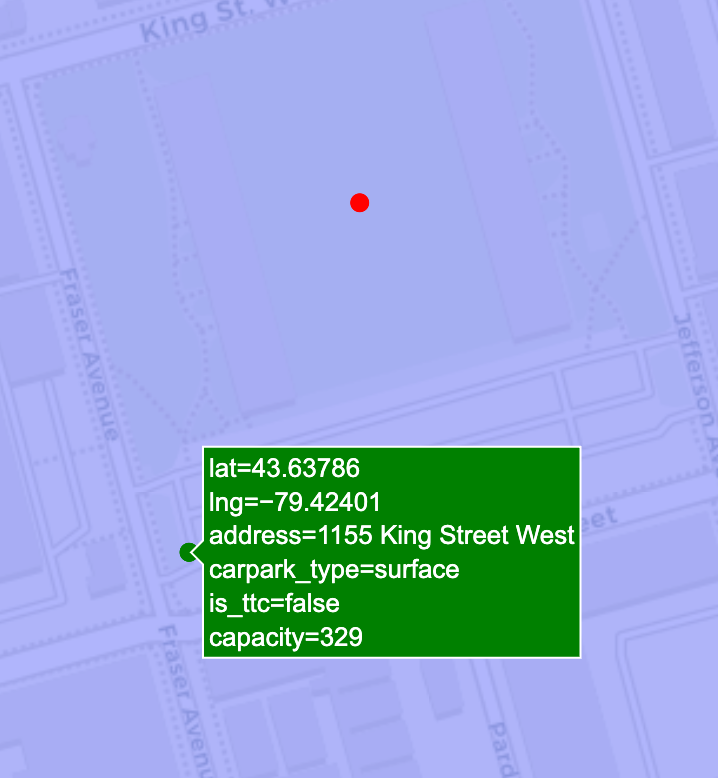

In [181]:

png_list = []  # empty list to append png files
root = "/Users/harshpanchal/Desktop/City of Toronto/images" # path for all pngs
for path, subdir, files in os.walk(root):
    for name in files:
        png_list.append(os.path.join(path,name))  # append all png files
        
Image(png_list[0])

3) Are there any socio-demographic trends of note in the areas with more infractions?

In [188]:
neighbor_prof_df[["Category","Topic","Characteristic",'Annex','Bay Street Corridor','Church-Yonge Corridor',
                  'Mimico (includes Humber Bay Shores)', 'Moss Park', 'Niagara', 'Waterfront Communities-The Island'
                  ,'Attribute']]

Category  \
0     Neighbourhood Information   
1     Neighbourhood Information   
2                    Population   
3                    Population   
4                    Population   
...                         ...   
6136                   Mobility   
6137                   Mobility   
6138                   Mobility   
6139                   Mobility   
6140                   Mobility   

                                                 Topic  \
0                            Neighbourhood Information   
1                            Neighbourhood Information   
2                             Population and dwellings   
3                             Population and dwellings   
4                             Population and dwellings   
...                                                ...   
6136  Mobility status - Place of residence 5 years ago   
6137  Mobility status - Place of residence 5 years ago   
6138  Mobility status - Place of residence 5 years ago   
6139  Mobility status - Place of residence 5 years ago   
6140  Mobility status - Place of residence 5 years ago   

                   Characteristic           Annex Bay Street Corridor  \
0            Neighbourhood Number              95                  76   
1            TSNS2020 Designation  No Designation      No Designation   
2                Population, 2016          30,526              25,797   
3                Population, 2011          29,177              19,348   
4     Population Change 2011-2016           4.60%              33.30%   
...                           ...             ...                 ...   
6136                          NaN          6515.0              5355.0   
6137                          NaN          4105.0              2990.0   
6138                          NaN          2545.0              1995.0   
6139                          NaN          1570.0              1000.0   
6140                          NaN          2390.0              2360.0   

     Church-Yonge Corridor Mimico (includes Humber Bay Shores)  \
0                       75                                  17   
1           No Designation                      No Designation   
2                   31,340                              33,964   
3                   28,349                              26,541   
4                   10.60%                              28.00%   
...                    ...                                 ...   
6136                6895.0                              4780.0   
6137                4495.0                              2545.0   
6138                3045.0                              1920.0   
6139                1450.0                               610.0   
6140                2405.0                              2245.0   

           Moss Park         Niagara Waterfront Communities-The Island  \
0                 73              82                                77   
1     No Designation  No Designation                    No Designation   
2             20,506          31,180                            65,913   
3             16,306          21,274                            43,361   
4             25.80%          46.60%                            52.00%   
...              ...             ...                               ...   
6136          1375.0          2785.0                            4815.0   
6137           440.0          1675.0                            3160.0   
6138           335.0          1265.0                            2320.0   
6139           110.0           415.0                             845.0   
6140           930.0          1105.0                            1675.0   

                             Attribute  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  
...                                ...  
6136                          Migrants  
6137              

With the above data set, I used data provided on the website "https://neptis.org/publications/chapters/socioeconomic-profiles". 

- According to the top 20 infractions sites, the most infraction occurs in "Bay Street Corridor", "Church-Yonge Corridor" and "Annex". Then "Moss Park", "Water Front Communities" and "Niagara". These places are the part of Downtown Toronto. If we check the age wise distribution, majority people are young between 19-34 years. The houshold income is also highest in these regions. In past years the migration and population rate has also increased. Education is also higher than other regions with more than 50% people with university degree. (We can not correlate education with infraction rate.)
- Considering a fact that in these regions the number of green p parking sites are more compared to other places though the infraction rate is high in Downtown Toronto. This might be due to unawareness of green p parking. People might not be aware of how to utilise green p parking or they might now be familiar with this parking system. 
- The another reason could be Downtown Toronto is a finacial hub. Most of the comapnies are located in downtown. The daily commute is higher in these regions than other regions in Toronto. 
- Regions like Scarborough and North york, the infraction rate is low as comapred to Downtown regions. This might be due to these regions are more of a residential area. People are not visiting these places for any site seeing. 

# FINAL MAP:

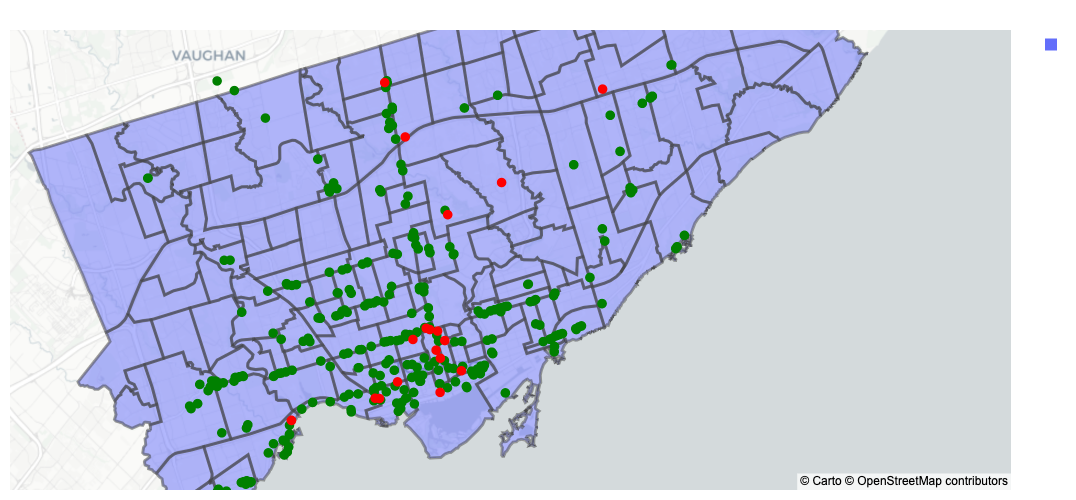

In [185]:
''' this is just a screen shot but the original map is interactive map. You can hover over the map and 
get different information regarding the green and red dots.'''

Image("final_result.png")  

